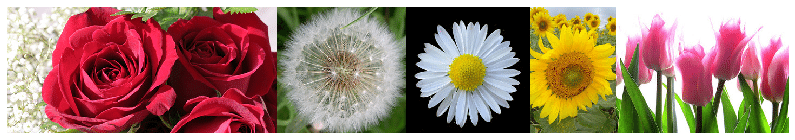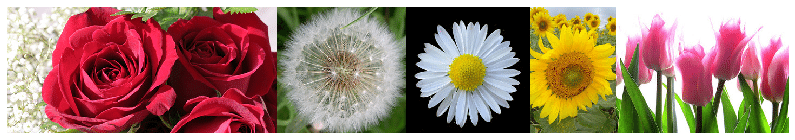

**In this multiclass flower classification project, I compared CNN with transfer learning algorithms like MobileNet and Xception. While both are pre-trained for image recognition, MobileNet's efficiency proved better for the flower dataset, achieving higher accuracy in distinguishing flower species.**

**I would be grateful if you could review this notebook in which I compared the performance of six different transfer learning models on the same dataset**

https://www.kaggle.com/code/adnanyaramis/flower-recognition

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import random
import PIL
import tensorflow as tf
from tensorflow.keras.layers import Activation, Dense, Flatten, Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.resnet import ResNet152, preprocess_input, decode_predictions, ResNet50
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img
import seaborn as sns

In [56]:
import os
import shutil
import random

data_dir = "/kaggle/input/flowers-recognition/flowers"


train_dir = "path/to/your/train_data"
test_dir = "path/to/your/test_data"
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)


classes = os.listdir(data_dir)


train_ratio = 0.90


for cls in classes:
    class_dir = os.path.join(data_dir, cls)
    images = os.listdir(class_dir)
    random.shuffle(images)
    train_size = int(len(images) * train_ratio)
    train_images = images[:train_size]
    test_images = images[train_size:]


    for img in train_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(train_dir, cls, img)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

    for img in test_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(test_dir, cls, img)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

print("Train-test split completed successfully.")

Train-test split completed successfully.


In [57]:
# Kinds of flowers
kinds = np.array(os.listdir('/kaggle/input/flowers-recognition/flowers'))
print(f"Flower kinds in dataset: {kinds}")

Flower kinds in dataset: ['dandelion' 'daisy' 'sunflower' 'tulip' 'rose']


In [58]:
# Paths of directories
path = '/kaggle/input/flowers-recognition/flowers'
kind_path = [path + "/" + flower for flower in kinds]
kind_path

['/kaggle/input/flowers-recognition/flowers/dandelion',
 '/kaggle/input/flowers-recognition/flowers/daisy',
 '/kaggle/input/flowers-recognition/flowers/sunflower',
 '/kaggle/input/flowers-recognition/flowers/tulip',
 '/kaggle/input/flowers-recognition/flowers/rose']

In [59]:
# Numbers of flowers for each kinds
for i, kind in enumerate(kind_path):
    print(f"There are {len(os.listdir(kind))} flowers in {kinds[i]}")

There are 1052 flowers in dandelion
There are 764 flowers in daisy
There are 733 flowers in sunflower
There are 984 flowers in tulip
There are 784 flowers in rose


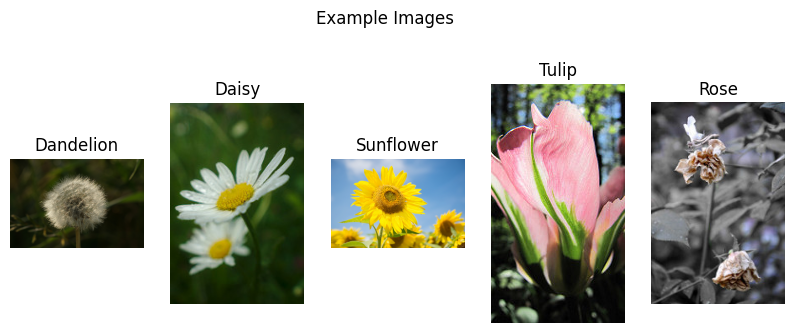

In [60]:
# Example images for each kinds
plt.figure(figsize=(10,4))
plt.suptitle("Example Images")
for i, kind in enumerate(kinds):
    ax = plt.subplot(1, 5, i+1)
    path = kind_path[i] + "/" + os.listdir(kind_path[i])[1]
    img = plt.imread(path)
    plt.imshow(img)
    plt.title(kind.capitalize())
    plt.axis("off")

In [61]:
# All ids
id_df = []
for i in range(len(kinds)):
    id = [img.split(".")[0] for img in os.listdir(kind_path[i])]
    id_df = id_df + id
len(id_df)

4317

In [62]:
# All kinds
kind_df = []
for i, kind in enumerate(kinds):
    for x in range(len(os.listdir(kind_path[i]))):
        kind_df.append(kind)
len(kind_df)

4317

In [63]:
# Create a dataframe
df = pd.DataFrame(columns=["id", "kind"])
df["id"] = id_df
df["kind"] = kind_df
df.tail()

,id,kind
4312,7820626638_3e2d712303,rose
4313,5148639829_781eb7d346,rose
4314,5335946401_f49bfbe3f9_n,rose
4315,8063462557_e0a8bd6c64_n,rose
4316,2536282942_b5ca27577e,rose


In [64]:
# Check numbers
df["kind"].value_counts(normalize = True)

kind
dandelion    0.243688
tulip        0.227936
rose         0.181608
daisy        0.176975
sunflower    0.169794
Name: proportion, dtype: float64

In [65]:
filenames = []
for i in range(len(kinds)):
    file = [kind_path[i] + "/" + kind for kind in os.listdir(kind_path[i])]
    filenames = filenames + file
filenames[:5]

['/kaggle/input/flowers-recognition/flowers/dandelion/34578947551_863af3acb3_n.jpg',
 '/kaggle/input/flowers-recognition/flowers/dandelion/2625836599_03e192266f.jpg',
 '/kaggle/input/flowers-recognition/flowers/dandelion/16242239484_51286673af.jpg',
 '/kaggle/input/flowers-recognition/flowers/dandelion/5716633491_55e6f02645_n.jpg',
 '/kaggle/input/flowers-recognition/flowers/dandelion/34697163155_5dc2571f23_n.jpg']

In [66]:
# Check a random flower
print(filenames[2317])
print(df.loc[2317])

/kaggle/input/flowers-recognition/flowers/sunflower/8174935013_b16626b49b.jpg
id      8174935013_b16626b49b
kind                sunflower
Name: 2317, dtype: object


In [67]:
boolean_kinds = [kind == kinds for kind in kind_df]
boolean_kinds[:5]

[array([ True, False, False, False, False]),
 array([ True, False, False, False, False]),
 array([ True, False, False, False, False]),
 array([ True, False, False, False, False]),
 array([ True, False, False, False, False])]

# **Train and Test Split**

In [68]:
X = filenames
y = boolean_kinds

In [69]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.1,
                                                    random_state=1,
                                                   stratify = y)
len(X_train), len(X_test), len(y_train), len(y_test)

(3885, 432, 3885, 432)

# **Image Preprocessing**

In [70]:
image = imread(filenames[1])
image.shape

(333, 500, 3)

In [71]:
# turn image into a tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 500, 3), dtype=uint8, numpy=
array([[[38, 30, 11],
        [38, 30, 11],
        [38, 30, 11],
        ...,
        [30, 37,  6],
        [31, 36,  6],
        [31, 36,  4]],

       [[38, 30, 11],
        [38, 30, 11],
        [37, 29, 10],
        ...,
        [31, 38,  5],
        [31, 38,  5],
        [33, 38,  6]]], dtype=uint8)>

In [72]:
# Create a function for preprocessing images
def process_image(image_path, img_size=256):
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[img_size, 256])

  return image

In [73]:
process_image(X[17]), tf.constant(y[17])

(<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
 array([[[0.04313726, 0.03137255, 0.01176471],
         [0.04339067, 0.03162597, 0.01201812],
         [0.04500248, 0.03323777, 0.01362993],
         ...,
         [0.03379289, 0.02987133, 0.01026348],
         [0.03529412, 0.03137255, 0.01176471],
         [0.03529412, 0.03137255, 0.01176471]],
 
        [[0.04313726, 0.03137255, 0.01176471],
         [0.04583136, 0.03406665, 0.01445881],
         [0.04705883, 0.03529412, 0.01568628],
         ...,
         [0.03337821, 0.02945665, 0.0098488 ],
         [0.03529412, 0.03137255, 0.01176471],
         [0.03529412, 0.03137255, 0.01176471]],
 
        [[0.04313726, 0.03137255, 0.01176471],
         [0.04410999, 0.03234528, 0.01273744],
         [0.04705883, 0.03529412, 0.01568628],
         ...,
         [0.03287378, 0.02895221, 0.00934436],
         [0.03529412, 0.03137255, 0.01176471],
         [0.03529412, 0.03137255, 0.01176471]],
 
        ...,
 
        [[0.45161214, 0.35360354

# **Data Augmentation**

In [74]:
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split = 0.2,
    rescale = 1/255
)

In [75]:
batch_size = 32
img_height = 256
img_width = 256

In [76]:
training_data = image_gen.flow_from_directory(
    train_dir,
    subset = "training",
    class_mode="categorical",
    target_size = (img_width, img_height),
    batch_size = batch_size,
    shuffle = False
)

validation_data = image_gen.flow_from_directory(
    train_dir,
    subset = "validation",
    class_mode="categorical",
    target_size = (img_width, img_height),
    batch_size = batch_size,
    shuffle = False
)

Found 3416 images belonging to 5 classes.
Found 853 images belonging to 5 classes.


In [77]:
image_shape = (256,256,3)

# **CNN Model**

In [78]:
# to select the weights for the epoch with the highest val_score

class GetBestModel(tf.keras.callbacks.Callback):
    def __init__(self, monitor = "val_loss", verbose = 0, mode = "auto"):
        super(GetBestModel, self).__init__()
        self.monitor = monitor
        self.verbose = verbose
        self.mode = mode
        if self.mode == "min":
            self.best = np.Inf
        else:
            self.best = -np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if self.mode == "min" and current < self.best:
            self.best = current
            self.best_weights = self.model.get_weights()
        elif self.mode == "max" and current > self.best:
            self.best = current
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs=None):
        self.model.set_weights(self.best_weights)

In [79]:
best_model = GetBestModel(monitor = "val_loss", mode = "min", verbose = 1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10)

In [80]:
model = Sequential()

model.add(Conv2D(filters=128, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
          
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 254, 254, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 127, 127, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 127, 127, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 125, 125, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 62, 62, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 62, 62, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 30, 30, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 12, 12, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,368,645 (9.04 MB)

 Trainable params: 2,366,597 (9.03 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [81]:
results = model.fit(training_data,epochs=25,
                    validation_data=validation_data,
                    callbacks = [early_stop, best_model])

Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1714722160.674183      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/107 ━━━━━━━━━━━━━━━━━━━━ 2s 415ms/step - accuracy: 0.2043 - loss: 1.7865

W0000 00:00:1714722247.018002      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 829ms/step - accuracy: 0.2038 - loss: 1.7788

W0000 00:00:1714722250.828313      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


107/107 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.2037 - loss: 1.7778 - val_accuracy: 0.1758 - val_loss: 1.6166
Epoch 2/25


W0000 00:00:1714722278.642815      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


107/107 ━━━━━━━━━━━━━━━━━━━━ 58s 511ms/step - accuracy: 0.2003 - loss: 1.6183 - val_accuracy: 0.2286 - val_loss: 1.6044
Epoch 3/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 58s 509ms/step - accuracy: 0.2565 - loss: 1.5956 - val_accuracy: 0.2462 - val_loss: 1.5948
Epoch 4/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 57s 506ms/step - accuracy: 0.2110 - loss: 1.6103 - val_accuracy: 0.2802 - val_loss: 1.5895
Epoch 5/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 58s 512ms/step - accuracy: 0.2867 - loss: 1.5991 - val_accuracy: 0.2567 - val_loss: 1.5909
Epoch 6/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 58s 515ms/step - accuracy: 0.2363 - loss: 1.6120 - val_accuracy: 0.3107 - val_loss: 1.5808
Epoch 7/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 57s 507ms/step - accuracy: 0.2874 - loss: 1.5837 - val_accuracy: 0.2708 - val_loss: 1.5834
Epoch 8/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 58s 512ms/step - accuracy: 0.2038 - loss: 1.6083 - val_accuracy: 0.3001 - val_loss: 1.5827
Epoch 9/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 58s 510ms/step - accuracy: 0.2740 - loss: 1.5957 - val

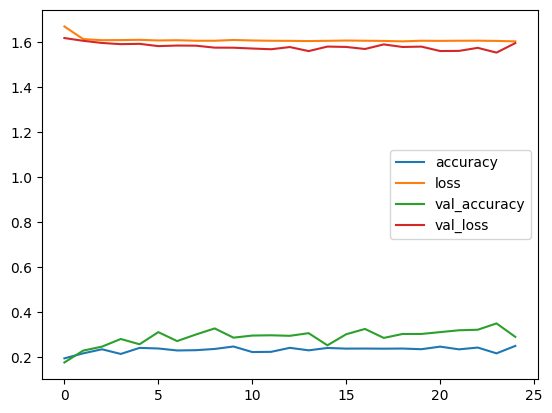

In [82]:
pd.DataFrame(results.history).plot();

In [83]:
summary = pd.DataFrame(model.history.history)
summary.head(15)

,accuracy,loss,val_accuracy,val_loss
0,0.194087,1.668019,0.175850,1.616644
1,0.216335,1.612019,0.228605,1.604409
2,0.234485,1.607136,0.246190,1.594815
3,0.213700,1.607631,0.280188,1.589525
4,0.240632,1.608726,0.256741,1.590929
5,0.237998,1.605890,0.310668,1.580799
6,0.229215,1.606958,0.270809,1.583370
7,0.230386,1.604686,0.300117,1.582734
8,0.235948,1.604654,0.327081,1.574034
9,0.246780,1.608054,0.286049,1.573768


In [84]:
preds = model.predict(validation_data)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

target_names = ['daisy','dandelion','rose','sunflower','tulip']
print(classification_report(validation_data.classes, y_pred, target_names= target_names))

 2/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step  

W0000 00:00:1714723664.191852      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 404ms/step
[1 1 1 4 4 4 1 1 1 4 1 4 1 4 1 4 4 4 1 1 1 4 1 4 4 1 1 1 1 1 4 1 4 4 1 4 1
 1 1 1 4 4 2 4 1 1 4 4 1 4 4 1 4 1 4 4 4 1 4 1 1 1 4 4 1 4 4 1 1 4 4 4 1 1
 1 1 1 4 1 4 4 4 1 1 1 1 1 1 4 1 1 4 4 1 1 1 4 4 1 4 1 4 1 4 4 1 4 4 4 4 4
 2 4 4 4 1 4 1 1 1 4 4 1 4 4 1 1 4 4 4 4 1 4 4 1 1 1 1 4 1 1 4 4 4 1 1 4 1
 4 1 1 4 4 1 1 1 1 1 4 1 1 1 4 1 1 1 1 1 1 1 4 1 1 4 1 4 4 1 1 4 1 4 1 1 4
 1 1 1 1 4 4 4 4 1 1 1 1 1 4 1 4 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 4 1 1 1 1 1 4 1 4 1 4 1 1
 1 1 4 3 1 1 4 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 4 1
 1 4 1 1 1 4 1 1 1 4 1 4 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1 4 1 4 1 1 1 1 1 4
 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 4 4 1 1 1 1 4 1 4 4 4 1 4 4 4 4 4 1
 1 4 4 4 1 1 1 4 4 4 4 4 4 1 1 4 1 1 1 1 4 1 1 4 1 4 1 4 1 4 1 1 4 4 1 1 4
 1 1 4 4 4 1 1 1 4 1 4 4 4 4 4 1 4 4 4 4 4 4 4 4 4 1 1 4 4 1 4 1 4 1 4 4 4
 4 1 4 4 4 1 1 4 4 1 1 4 4 4 4 4 2 4 1 1 2 4 4 4 4 4 4 4 4

W0000 00:00:1714723674.705364      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha

# **Xception Model**

In [87]:
xception_model = Sequential()

pretrained_model= tf.keras.applications.Xception(include_top=False,
                   input_shape=image_shape,
                   pooling='avg',
                   weights= 'imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

xception_model.add(pretrained_model)
xception_model.add(Flatten())
xception_model.add(Dense(512, activation='relu'))
xception_model.add(Dense(512, activation='relu'))
xception_model.add(Dense(512, activation='relu'))
xception_model.add(Dense(5, activation='softmax'))
xception_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

xception_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ ?                      │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [88]:
early_stop = EarlyStopping(monitor='val_loss',patience=10)
results = xception_model.fit(training_data,epochs=25,
                    validation_data=validation_data,
                    callbacks=[early_stop, best_model])

Epoch 1/25
  1/107 ━━━━━━━━━━━━━━━━━━━━ 18:56 11s/step - accuracy: 0.0938 - loss: 1.5689

W0000 00:00:1714724506.220204      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 81/107 ━━━━━━━━━━━━━━━━━━━━ 16s 620ms/step - accuracy: 0.2915 - loss: 1.6999

W0000 00:00:1714724555.902259      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.3204 - loss: 1.6147

W0000 00:00:1714724568.363599      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


107/107 ━━━━━━━━━━━━━━━━━━━━ 97s 814ms/step - accuracy: 0.3215 - loss: 1.6116 - val_accuracy: 0.6389 - val_loss: 0.8116
Epoch 2/25


W0000 00:00:1714724592.437607      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


107/107 ━━━━━━━━━━━━━━━━━━━━ 57s 502ms/step - accuracy: 0.7022 - loss: 0.8069 - val_accuracy: 0.7913 - val_loss: 0.5669
Epoch 3/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 57s 504ms/step - accuracy: 0.8010 - loss: 0.5522 - val_accuracy: 0.8324 - val_loss: 0.4626
Epoch 4/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 57s 499ms/step - accuracy: 0.8203 - loss: 0.4857 - val_accuracy: 0.8042 - val_loss: 0.5290
Epoch 5/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 57s 502ms/step - accuracy: 0.8254 - loss: 0.5066 - val_accuracy: 0.8288 - val_loss: 0.4834
Epoch 6/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 57s 502ms/step - accuracy: 0.8246 - loss: 0.4693 - val_accuracy: 0.8570 - val_loss: 0.4265
Epoch 7/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 57s 502ms/step - accuracy: 0.8597 - loss: 0.3957 - val_accuracy: 0.7655 - val_loss: 0.6507
Epoch 8/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 56s 498ms/step - accuracy: 0.8319 - loss: 0.4638 - val_accuracy: 0.8441 - val_loss: 0.4338
Epoch 9/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 56s 501ms/step - accuracy: 0.8816 - loss: 0.3416 - val

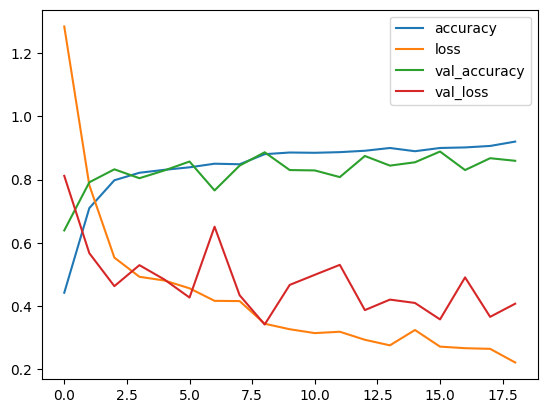

In [89]:
pd.DataFrame(results.history).plot();

In [90]:
summary = pd.DataFrame(xception_model.history.history)
summary.head(15)

,accuracy,loss,val_accuracy,val_loss
0,0.441745,1.284490,0.638921,0.811646
1,0.709602,0.782158,0.791325,0.566925
2,0.797717,0.552872,0.832356,0.462552
3,0.821429,0.492186,0.804220,0.528976
4,0.830796,0.480392,0.828839,0.483424
5,0.838700,0.455704,0.856975,0.426489
6,0.850117,0.416052,0.765533,0.650724
7,0.848361,0.415215,0.844080,0.433801
8,0.880269,0.343586,0.886284,0.341176
9,0.885539,0.326136,0.830012,0.466492


In [91]:
preds = xception_model.predict(validation_data)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

target_names = ['daisy','dandelion','rose','sunflower','tulip']
print(classification_report(validation_data.classes, y_pred, target_names= target_names))

 2/27 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step

W0000 00:00:1714725617.960250      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 497ms/step
[0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 4
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 2 0 0 0 0 1 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 4 0
 0 2 1 1 1 1 1 1 1 1 3 1 1 1 1 1 4 1 1 1 1 1 1 1 1 2 1 1 1 1 1 4 1 1 1 1 4
 1 1 1 1 3 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 2 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 2 1 1 1 1 1 1 3 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1
 1 1 1 1 1 3 1 4 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 4 2 2 2 2 4 2
 2 2 2 2 2 2 2 4 2 2 2 2 4 2 2 2 2 4 2 2 2 2 4 2 2 2 2 2 2 2 4 2 2 2 2 2 2
 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2
 2 2 2 2 2 2 2 2 2 4 2 2 4 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2

W0000 00:00:1714725630.870710      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


# **MobilNetV2 Model**

In [92]:
mobilenet_model = Sequential()
pretrained_model= tf.keras.applications.MobileNetV2(include_top=False,
                   input_shape=image_shape,
                   pooling='avg',
                   weights= 'imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

mobilenet_model.add(pretrained_model)
mobilenet_model.add(Flatten())
mobilenet_model.add(Dense(512, activation='relu'))
mobilenet_model.add(Dense(512, activation='relu'))
mobilenet_model.add(Dense(5, activation='softmax'))
mobilenet_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

mobilenet_model.summary()

/tmp/ipykernel_34/3061270787.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pretrained_model= tf.keras.applications.MobileNetV2(include_top=False,


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [94]:
early_stop = EarlyStopping(monitor='val_loss',patience=10)
results = mobilenet_model.fit(training_data,epochs=25,
                    validation_data=validation_data,
                    callbacks=[early_stop])

Epoch 1/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 57s 503ms/step - accuracy: 0.9663 - loss: 0.0996 - val_accuracy: 0.8605 - val_loss: 0.5142
Epoch 2/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 55s 492ms/step - accuracy: 0.9582 - loss: 0.1066 - val_accuracy: 0.8781 - val_loss: 0.4166
Epoch 3/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 55s 489ms/step - accuracy: 0.9687 - loss: 0.0823 - val_accuracy: 0.8628 - val_loss: 0.5148
Epoch 4/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 56s 494ms/step - accuracy: 0.9646 - loss: 0.0913 - val_accuracy: 0.8581 - val_loss: 0.5390
Epoch 5/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 56s 493ms/step - accuracy: 0.9649 - loss: 0.1100 - val_accuracy: 0.8792 - val_loss: 0.4993
Epoch 6/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 55s 491ms/step - accuracy: 0.9483 - loss: 0.1385 - val_accuracy: 0.8898 - val_loss: 0.4044
Epoch 7/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 55s 489ms/step - accuracy: 0.9766 - loss: 0.0688 - val_accuracy: 0.8359 - val_loss: 0.5489
Epoch 8/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 55s 491ms/step - accuracy: 0.9770 - loss: 0

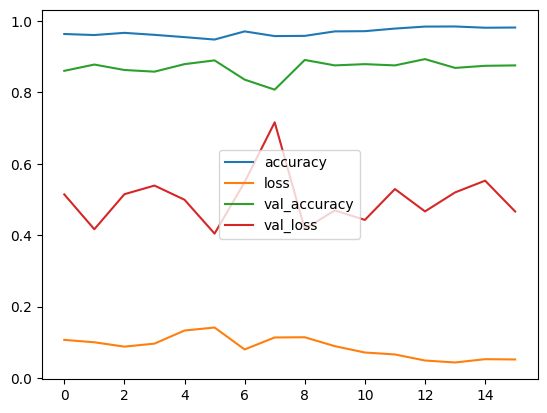

In [95]:
pd.DataFrame(results.history).plot();

In [96]:
summary = pd.DataFrame(mobilenet_model.history.history)
summary.head(15)

,accuracy,loss,val_accuracy,val_loss
0,0.963700,0.106587,0.860492,0.514248
1,0.960773,0.099884,0.878077,0.416605
2,0.966920,0.087677,0.862837,0.514759
3,0.961358,0.096089,0.858148,0.539011
4,0.954918,0.132818,0.879250,0.499275
5,0.948185,0.141249,0.889801,0.404416
6,0.971019,0.079780,0.835873,0.548878
7,0.957845,0.113376,0.807737,0.716248
8,0.958431,0.113944,0.890973,0.417545
9,0.971019,0.088981,0.875733,0.469395


In [97]:
preds = mobilenet_model.predict(validation_data)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

target_names = ['daisy','dandelion','rose','sunflower','tulip']
print(classification_report(validation_data.classes, y_pred, target_names= target_names))

 1/27 ━━━━━━━━━━━━━━━━━━━━ 1:24 3s/step

W0000 00:00:1714727907.428173      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 507ms/step
[0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0
 0 4 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 2 0 4 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 4 0
 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 1 1 4 1 1 1 1 3
 3 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 3 0 1 1 1 1 4 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 0 1
 0 1 1 3 1 2 1 2 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 4 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 3 1 1 1 1 1 1 3 1 1 1 1 1 2 1 1 3 0 1 1 1 1 1 1 2 2 2 2 4 4 2 4 2 2 2 2
 4 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2
 4 4 4 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2
 2 2 2 2 2 2 4 2 2 3 2 2 4 2 2 4 3 2 2 2 2 2 2 2 2 2 2 2 2

W0000 00:00:1714727920.608444      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


# **Model Comparison**

In [98]:
print('======CNN Model=========')

preds = model.predict(validation_data)
y_pred = np.argmax(preds, axis=1)
target_names = ['daisy','dandelion','rose','sunflower','tulip']
print(classification_report(validation_data.classes, y_pred, target_names= target_names))

print('======Xception=========')

preds = xception_model.predict(validation_data)
y_pred = np.argmax(preds, axis=1)
target_names = ['daisy','dandelion','rose','sunflower','tulip']
print(classification_report(validation_data.classes, y_pred, target_names= target_names))

print('======MobileNetV2=========')

preds = mobilenet_model.predict(validation_data)
y_pred = np.argmax(preds, axis=1)
target_names = ['daisy','dandelion','rose','sunflower','tulip']
print(classification_report(validation_data.classes, y_pred, target_names= target_names))

======CNN Model=========
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 399ms/step
              precision    recall  f1-score   support

       daisy       0.00      0.00      0.00       150
   dandelion       0.35      0.78      0.48       208
        rose       0.30      0.02      0.04       155
   sunflower       0.50      0.01      0.01       146
       tulip       0.33      0.65      0.44       194

    accuracy                           0.34       853
   macro avg       0.30      0.29      0.19       853
weighted avg       0.30      0.34      0.23       853

======Xception=========


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 406ms/step
              precision    recall  f1-score   support

       daisy       0.96      0.87      0.91       150
   dandelion       0.92      0.89      0.91       208
        rose       0.78      0.86      0.82       155
   sunflower       0.87      0.84      0.85       146
       tulip       0.83      0.87      0.85       194

    accuracy                           0.87       853
   macro avg       0.87      0.87      0.87       853
weighted avg       0.87      0.87      0.87       853

======MobileNetV2=========
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 403ms/step
              precision    recall  f1-score   support

       daisy       0.89      0.89      0.89       150
   dandelion       0.95      0.85      0.90       208
        rose       0.84      0.86      0.85       155
   sunflower       0.90      0.92      0.91       146
       tulip       0.84      0.90      0.87       194

    accuracy                           0.88       853
   macro avg       0